# Importing

In [ ]:
# # keep runtime
# function ClickConnect(){
# console.log("Working"); 
# document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
# }
# var clicker = setInterval(ClickConnect,60000);
# # stop keeping runtime 
# clearInterval(clicker);

from google.colab import drive
drive.mount('/content/drive')

!pip install --upgrade catboost
!pip install --upgrade tensorflow-addons
!pip install --upgrade keras-tuner
!pip install --upgrade optuna
!pip install --upgrade statsmodels
!pip install --upgrade wandb
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/projects/DA_Platform/")
from DA_v5 import *


import wandb
from wandb.keras import WandbCallback
from optuna.integration.wandb import WeightsAndBiasesCallback as optuna_wnbcallback
import shutil

from glob import glob
from IPython.display import Image, display

# global setting
warnings.filterwarnings(action='ignore')
rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)
pd.set_option('max_colwidth', 200)

rcParams['axes.unicode_minus'] = False
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["WANDB_API_KEY"] = "6f810b088fcc6b9eaaa56c1e52cfd37836606240"

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

Mounted at /content/drive
     |████████████████████████████████| 76.3 MB 92.1 MB/s 
     |████████████████████████████████| 1.1 MB 9.9 MB/s 
     |████████████████████████████████| 98 kB 4.8 MB/s 
     |████████████████████████████████| 308 kB 7.5 MB/s 
     |████████████████████████████████| 209 kB 73.1 MB/s 
     |████████████████████████████████| 80 kB 11.2 MB/s 
     |████████████████████████████████| 75 kB 5.1 MB/s 
     |████████████████████████████████| 112 kB 92.1 MB/s 
     |████████████████████████████████| 149 kB 56.7 MB/s 
     |████████████████████████████████| 49 kB 7.2 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=811df3a0d00b6c9428a1b4016ac3542aa282a96abe9736c48e6d71a8152e6a5a
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
     |████████████████████████████████| 9.8 MB 7.0 MB/s 
  Attempting uninstall: statsmodels
    Found existin

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/"
AUTOTUNE = tf.data.experimental.AUTOTUNE
img_size = 224
channels = 3
target_var = "growth_day"
plant_type = "LT"

# Defining rawdata loading and preprocessing functions

In [ ]:
def extract_day(file_name):
    # 01, 02 등으로 된 문자열을 int로 변환하여 성장일 추출
    return int(file_name.split('.')[-2][-2:])

def make_train_dataframe(root_path=None, plant_type=None):
    # ex. /train_dataset/BC/_01, /train_dataset/BC/_02 등
    image_dir = glob(root_path + plant_type + "/*")
    image_dir = series(image_dir).sort_values()

    before_path = []
    after_path = []
    growth_day = []
    for i in image_dir: 
        images = glob(i + '/*.png')
        images = series(images).sort_values()
        cnt = 0
        for j in images.iloc[cnt:]:
            if len(images) - 1 == cnt: break
            for k in images.iloc[cnt+1:]:
                before_path.append(j)
                after_path.append(k)     
                growth_day.append(extract_day(k) - extract_day(j))
            cnt += 1

    result_df = dataframe({
        "before_path": before_path,
        "after_path": after_path,
        "growth_day": growth_day
    })
    return result_df

def make_test_dataframe(root_path=None, plant_type=None):
    test_metadata = read_csv(root_path + "test_data.csv")

    tmp_plant_type = []
    test_metadata.iloc[:,1].apply(lambda x: tmp_plant_type.append(x.split("_")[1]))
    test_metadata = test_metadata.drop("idx", axis=1)[series(tmp_plant_type).apply(lambda x: x == plant_type)]
    test_plant_idx = test_metadata.reset_index()["index"]; test_metadata.reset_index(drop=True, inplace=True)

    before_file_path = []
    after_file_path = []
    for i in range(test_metadata.shape[0]):
        path_data = test_metadata["before_file_path"].iloc[i].split("_")
        file_path = root_path + path_data[1] + "/" + path_data[2] + "/" + test_metadata["before_file_path"].iloc[i] + ".png"
        before_file_path.append(file_path)

        path_data = test_metadata["after_file_path"].iloc[i].split("_")
        file_path = root_path + path_data[1] + "/" + path_data[2] + "/" + test_metadata["after_file_path"].iloc[i] + ".png"
        after_file_path.append(file_path)

    test_metadata["before_file_path"] = before_file_path
    test_metadata["after_file_path"] = after_file_path
    test_metadata.columns = ["before_path", "after_path"]
    return test_metadata, test_plant_idx

# Loading rawdata and data check

In [ ]:
full_x = make_train_dataframe(folder_path + "dataset_224/train_dataset/", plant_type)
full_y = full_x["growth_day"].astype("float32"); full_x.drop("growth_day", axis=1, inplace=True)
test_x, test_plant_idx = make_test_dataframe(folder_path + "dataset_224/test_dataset/", plant_type)

In [ ]:
print(full_x.shape)
print(full_y.shape)
print(test_x.shape)

(7801, 2)
(7801,)
(2161, 2)


In [ ]:
full_x.head(10)

,before_path,after_path
0,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT01.png
1,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT02.png
2,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT03.png
3,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT04.png
4,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT05.png
5,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT06.png
6,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT07.png
7,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT08.png
8,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT09.png
9,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT00.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_01/DAT10.png


In [ ]:
full_x.tail(10)

,before_path,after_path
7791,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT35.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT36.png
7792,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT35.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT37.png
7793,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT35.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT38.png
7794,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT35.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT39.png
7795,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT36.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT37.png
7796,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT36.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT38.png
7797,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT36.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT39.png
7798,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT37.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT38.png
7799,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT37.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT39.png
7800,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT38.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/train_dataset/LT/LT_10/DAT39.png


In [ ]:
# Image(full_x.iloc[0,0])

In [ ]:
# Image(full_x.iloc[0,1])

In [ ]:
test_x.head(10)

,before_path,after_path
0,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00341.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00154.png
1,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00592.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00687.png
2,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00681.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00698.png
3,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00132.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00333.png
4,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00762.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00698.png
5,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00264.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00671.png
6,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00171.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00034.png
7,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00470.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00985.png
8,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00264.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00671.png
9,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00009.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00734.png


In [ ]:
test_x.tail(10)

,before_path,after_path
2151,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00801.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00526.png
2152,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00904.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00069.png
2153,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00577.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00889.png
2154,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00395.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1003/idx_LT_1003_00918.png
2155,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00801.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00526.png
2156,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00819.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00472.png
2157,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00470.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00594.png
2158,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00009.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00592.png
2159,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00620.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1088/idx_LT_1088_00698.png
2160,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00006.png,/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/dataset_224/test_dataset/LT/1089/idx_LT_1089_00442.png


In [ ]:
# Image(test_x.iloc[0,0])

In [ ]:
# Image(test_x.iloc[0,1])

In [ ]:
# # random sampling on before image
# seed_everything()
# for _ in range(10):
#     i = rnd.randint(test_x.shape[0])
#     display(Image(test_x.iloc[i,0]))
#     display(Image(test_x.iloc[i,1]))

# Defining tensorflow dataset functions

In [ ]:
from tensorflow.image import decode_png

# Augmenting the image
def image_preprocessing(augment):
    def image_read(x, y):
        # image read
        return_tuple = []
        for i in x:
            image = tf.io.read_file(i)
            image = tf.image.decode_png(image, channels=channels)
            # image = tf.ensure_shape(image, [img_size, img_size, channels])
            image = tf.cast(image, tf.float32)
            # image resize
            image = tf.image.resize(image, (img_size, img_size), method="lanczos5", antialias=True)
            return_tuple.append(image)
        return tuple(return_tuple), y
    def image_read_augment(x, y):
        # image read
        return_tuple = []
        for i in x:
            # print(x)
            image = tf.io.read_file(i)
            image = tf.image.decode_png(image, channels=channels)
            # image = tf.ensure_shape(image, [img_size, img_size, channels])
            image = tf.cast(image, tf.float32)
            # image resize
            image = tf.image.resize(image, (img_size, img_size), method="lanczos5", antialias=True)
            return_tuple.append(image)
        return tuple(return_tuple), y
    return image_read_augment if augment else image_read

# Creating the dataset
def create_dataset(img_x1=None, img_x2=None, y=None, batch_size=None, augment=False, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices(((img_x1, img_x2), y))
    dataset = dataset.map(image_preprocessing(augment), num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [ ]:
# tf dataset check
create_dataset(full_x[:10]["before_path"], full_x[:10]["after_path"], full_y[:10], batch_size=32, augment=True, shuffle=True)

<PrefetchDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3)), (None,)), types: ((tf.float32, tf.float32), tf.float32)>

In [ ]:
# tf dataset check
create_dataset(test_x[:10]["before_path"], test_x[:10]["after_path"], None, batch_size=32, augment=False, shuffle=False)

<PrefetchDataset shapes: (((None, 224, 224, 3), (None, 224, 224, 3)), NoneTensorSpec()), types: ((tf.float32, tf.float32), NoneTensorSpec())>

# Building Models - BiT_LP Try1

In [ ]:
# ====== BiT_LP Try1 =====
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "BiT_LP_Try1"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x1/1", trainable=False)

# def createNN_BiT(): 
#     B0_input = layers.Input(shape=(img_size, img_size, channels))
    
#     # ===== BiT model (base architecture : ResNet50) =====
#     x = pretrained_model(B0_input)
#     x = layers.Dropout(dropoutRate)(x)
    
#     # ===== down sampling to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final = layers.PReLU()(x)

#     return Model(B0_input, layer_final)

# def createNN_LearningLayers(model_img_x1, model_img_x2):
#     # === input layers ===
#     B0_input_subtract = layers.Subtract()([model_img_x2.get_layer(index=-1).output, model_img_x1.get_layer(index=-1).output])
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([model_img_x1.get_layer(index=-1).output, model_img_x2.get_layer(index=-1).output, B0_input_subtract])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_dense)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dropout])

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu"), name="B2_dense"
#     )(B1_concat)
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_dense)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dropout, B2_dropout])

#     B3_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu"), name="B3_dense"
#     )(B2_concat)
#     B3_dropout = layers.Dropout(rate=dropoutRate, name="B3_dropout")(B3_dense)

#     # === top layers ===
#     layer_final = layers.Dense(units=int(hiddenLayers / 2), activation="relu", name="layer_final")(B3_dropout)
#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([model_img_x1.get_layer(index=0).output, model_img_x2.get_layer(index=0).output], layer_regressor)

# Building Models - BiT_LP Try2

In [ ]:
# # ====== BiT_LP Try2 =====
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "BiT_LP_Try2"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x1/1", trainable=False)

# def createNN_LearningLayers():
#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_1 = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x_img_1)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_2 = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x_img_2)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== Subtract layer (base architecture : ResNet50) =====
#     B0_input_subtract = layers.Subtract()([x_img_2, x_img_1])
#     x = layers.Dropout(dropoutRate)(B0_input_subtract)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_dense)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dropout])

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu"), name="B2_dense"
#     )(B1_concat)
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_dense)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dropout, B2_dropout])

#     B3_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu"), name="B3_dense"
#     )(B2_concat)
#     B3_dropout = layers.Dropout(rate=dropoutRate, name="B3_dropout")(B3_dense)

#     # === top layers ===
#     layer_final = layers.Dense(units=int(hiddenLayers / 2), activation="relu", name="layer_final")(B3_dropout)
#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

# Building Models - BiT_LP Try3

In [ ]:
# # ====== BiT_LP Try3 =====
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "BiT_LP_Try3"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x1/1", trainable=False)

# def createNN_LearningLayers():
#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_1 = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x_img_1)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 8))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_2 = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x_img_2)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 8))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== Subtract layer (base architecture : ResNet50) =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     x_img_3 = pretrained_model(B0_input_subtract)
#     x = layers.Dropout(dropoutRate)(x_img_3)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 8))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_dense)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dropout])

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu"), name="B2_dense"
#     )(B1_concat)
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_dense)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dropout, B2_dropout])

#     B3_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu"), name="B3_dense"
#     )(B2_concat)
#     B3_dropout = layers.Dropout(rate=dropoutRate, name="B3_dropout")(B3_dense)

#     # === top layers ===
#     layer_final = layers.Dense(units=int(hiddenLayers / 2), activation="relu", name="layer_final")(B3_dropout)
#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

# Building Models - BiT_LP Try4

In [ ]:
# # ====== BiT_LP Try4 =====
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "BiT_LP_Try4"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x1/1", trainable=False)

# def createNN_LearningLayers():
#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_1 = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x_img_1)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 8))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_2 = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x_img_2)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 8))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # # ===== Subtract layer (base architecture : ResNet50) =====
#     # B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     # x_img_3 = pretrained_model(B0_input_subtract)
#     # x = layers.Dropout(dropoutRate)(x_img_3)
    
#     # # ===== down sizing to 128 =====
#     # x = layers.Dense(int(hiddenLayers * 8))(x)
#     # x = layers.PReLU()(x)
#     # x = layers.Dropout(dropoutRate)(x)

#     # x = layers.Dense(int(hiddenLayers * 4))(x)
#     # x = layers.PReLU()(x)
#     # x = layers.Dropout(dropoutRate)(x)

#     # x = layers.Dense(hiddenLayers * 2)(x)
#     # layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_dense)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dropout])

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu"), name="B2_dense"
#     )(B1_concat)
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_dense)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dropout, B2_dropout])

#     B3_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu"), name="B3_dense"
#     )(B2_concat)
#     B3_dropout = layers.Dropout(rate=dropoutRate, name="B3_dropout")(B3_dense)

#     # === top layers ===
#     layer_final = layers.Dense(units=int(hiddenLayers / 2), activation="relu", name="layer_final")(B3_dropout)
#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

# Building Models - EffinetB0_LP Try1

In [ ]:
# # ====== EffinetB0_LP Try1 =====
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "EffinetB0_LP_Try1"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1", trainable=False)

# def createNN_LearningLayers():
#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_1 = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x_img_1)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_2 = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x_img_2)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== Subtract layer (base architecture : ResNet50) =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     x_img_3 = pretrained_model(B0_input_subtract)
#     x = layers.Dropout(dropoutRate)(x_img_3)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_dense)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dropout])

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu"), name="B2_dense"
#     )(B1_concat)
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_dense)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dropout, B2_dropout])

#     B3_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu"), name="B3_dense"
#     )(B2_concat)
#     B3_dropout = layers.Dropout(rate=dropoutRate, name="B3_dropout")(B3_dense)

#     # === top layers ===
#     layer_final = layers.Dense(units=int(hiddenLayers / 2), activation="relu", name="layer_final")(B3_dropout)
#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

# Building Models - EffinetV2B0_LP Try1

In [ ]:
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "EffinetV2B0_LP_Try1"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2", trainable=False)

# def createNN_LearningLayers():
#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels))
    
#     x = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels))
    
#     x = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== Subtract layer (base architecture : ResNet50) =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     B0_input_subtract = Rescaling(1/255)(B0_input_subtract)

#     x = pretrained_model(B0_input_subtract)
#     x = layers.Dropout(dropoutRate)(x)
    
#     # ===== down sizing to 128 =====
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu", kernel_initializer="lecun_normal"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dense])
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_concat)

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu", kernel_initializer="lecun_normal"), name="B2_dense"
#     )(B1_dropout)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dense, B2_dense])
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_concat)

#     layer_final = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu", kernel_initializer="lecun_normal"), name="B3_dense"
#     )(B2_dropout)

#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

# Building Models - EffinetV2B0_LP Try2 (Blended)

In [ ]:
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "EffinetV2B0_LP_Try2"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
#                                      name="EfficientNet_V2_B0", trainable=False)

# def createNN_LearningLayers():
#     # ===== before image =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels), name="input_before")
    
#     x = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== after image =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels), name="input_after")
    
#     x = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== subtract layer =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     B0_input_subtract = Rescaling(1/255)(B0_input_subtract)

#     x = pretrained_model(B0_input_subtract)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu", kernel_initializer="lecun_normal"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dense])
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_concat)

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu", kernel_initializer="lecun_normal"), name="B2_dense"
#     )(B1_dropout)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dense, B2_dense])
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_concat)

#     layer_final = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu", kernel_initializer="lecun_normal"), name="B3_dense"
#     )(B2_dropout)

#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

In [ ]:
# def createNN_IndependentLearning():
#     # ===== before image =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels), name="input_before")
    
#     x = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     x = layers.PReLU()(x)

#     layer_final_1 = layers.Dense(1)(x)

#     # ===== after image =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels), name="input_after")
    
#     x = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers * 2)(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     x = layers.PReLU()(x)

#     layer_final_2 = layers.Dense(1)(x)

#     # ===== interval calculation =====
#     layer_regressor = layers.Subtract(name="regressor")([layer_final_2, layer_final_1])
#     return Model([B0_input_1, B0_input_2], layer_regressor)

# BiT_EffinetV2B0_MLPMixer Try1 (Blended)

In [ ]:
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "BiT_EffinetV2B0_MLPMixer_Try1"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model_effitnet = tf_hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
#                                      name="EfficientNet_V2_B0", trainable=False)
# rescaling_effinet = Rescaling(scale=1./255)

# def createNN_Effinet():
#     # ===== before image =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels), name="input_before")
#     x = RandomRotation(factor=(-0.2, 0.2))(B0_input_1)
#     x = rescaling_effinet(x)
    
#     x = pretrained_model_effitnet(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== after image =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels), name="input_after")
#     x = RandomRotation(factor=(-0.2, 0.2))(B0_input_2)
#     x = rescaling_effinet(x)
    
#     x = pretrained_model_effitnet(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== subtract layer =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     x = rescaling_effinet(B0_input_subtract)

#     x = pretrained_model_effitnet(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu", kernel_initializer="lecun_normal"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dense])
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_concat)

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu", kernel_initializer="lecun_normal"), name="B2_dense"
#     )(B1_dropout)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dense, B2_dense])
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_concat)

#     layer_final = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu", kernel_initializer="lecun_normal"), name="B3_dense"
#     )(B2_dropout)

#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

In [ ]:
# pretrained_model_bit = tf_hub.KerasLayer("https://tfhub.dev/google/bit/m-r50x1/1",
#                                      name="BiT_ResNet50", trainable=False)
# rescaling_bit = Rescaling(scale=1./255)

# def createNN_BiT():
#     # ===== before image =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels), name="input_before")
#     x = RandomRotation(factor=(-0.2, 0.2))(B0_input_1)
#     x = rescaling_bit(x)
    
#     x = pretrained_model_bit(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== after image =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels), name="input_after")
#     x = RandomRotation(factor=(-0.2, 0.2))(B0_input_2)
#     x = rescaling_bit(x)
    
#     x = pretrained_model_bit(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== subtract layer =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     x = rescaling_bit(B0_input_subtract)

#     x = pretrained_model_bit(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     x = layers.Dense(int(hiddenLayers * 4))(x)
#     x = layers.PReLU()(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu", kernel_initializer="lecun_normal"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dense])
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_concat)

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu", kernel_initializer="lecun_normal"), name="B2_dense"
#     )(B1_dropout)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dense, B2_dense])
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_concat)

#     layer_final = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu", kernel_initializer="lecun_normal"), name="B3_dense"
#     )(B2_dropout)

#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

In [ ]:
# pretrained_model_mlp_mixer = tf_hub.KerasLayer("https://tfhub.dev/sayakpaul/mixer_b16_i21k_fe/1",
#                                      name="MLP_Mixer", trainable=False)
# rescaling_mlp_mixer = Rescaling(scale=1./127.5, offset=-1)

# def createNN_MLP_Mixer():
#     # ===== before image =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels), name="input_before")
#     x = RandomRotation(factor=(-0.2, 0.2))(B0_input_1)
#     x = rescaling_mlp_mixer(x)
    
#     layer_final_1 = pretrained_model_mlp_mixer(x)

#     # ===== after image =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels), name="input_after")
#     x = RandomRotation(factor=(-0.2, 0.2))(B0_input_2)
#     x = rescaling_mlp_mixer(x)
    
#     layer_final_2 = pretrained_model_mlp_mixer(x)

#     # ===== subtract layer =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     x = rescaling_mlp_mixer(B0_input_subtract)

#     layer_final_3 = pretrained_model_mlp_mixer(x)

#     x = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])
#     x = layers.Dense(512, activation="relu", kernel_regularizer="l2")(x)
#     layer_final = layers.Dense(128, activation="relu")(x)

#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)

#     return Model([B0_input_1, B0_input_2], layer_regressor)

# BiT_MLPMixer Try1 (Blended)

In [ ]:
model_name = "BiT_EffinetV2B0_MLPMixer_Try2"

# NN model parameter setting
dropoutRate = 0.25

# pretrained model setting
pretrained_model_bit = tf_hub.KerasLayer("https://tfhub.dev/google/bit/s-r50x1/1",
                                    name="BiT_ResNet50", trainable=False)
pretrained_model_effitnet = tf_hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
                                    name="EfficientNet_V2_B0", trainable=False)
pretrained_model_mlp_mixer = tf_hub.KerasLayer("https://tfhub.dev/sayakpaul/mixer_b16_sam_fe/1",
                                    name="MLP_Mixer", trainable=False)

def createNN_prep(minmax_fromzero=True):
    model = Sequential([
        layers.Input(shape=(img_size, img_size, channels)),
        RandomColorDistortion(),
        layers.RandomZoom(height_factor=(-0.1, 0.0), width_factor=(-1.0, 0.0)),
        layers.RandomRotation((-0.1, 0.1)),
        layers.Rescaling(scale=1./255) if minmax_fromzero else layers.Rescaling(scale=1./127.5, offset=-1)
    ])
    return model

In [ ]:
def createNN_BiT():
    # ===== before image =====
    input_before = layers.Input(shape=(img_size, img_size, channels), name="input_before")
    x = createNN_prep(True)(input_before)
    
    x = pretrained_model_bit(x)
    x = layers.Dropout(dropoutRate)(x)

    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    fv_before = layers.Dense(256, activation="relu")(x)

    # ===== after image =====
    input_after = layers.Input(shape=(img_size, img_size, channels), name="input_after")
    x = createNN_prep(True)(input_after)
    
    x = pretrained_model_bit(x)
    x = layers.Dropout(dropoutRate)(x)

    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    fv_after = layers.Dense(256, activation="relu")(x)

    # ===== subtract layer =====
    input_subtract = layers.Subtract()([input_after, input_before])
    x = layers.Rescaling(scale=1./255)(input_subtract)
    
    x = pretrained_model_bit(x)
    x = layers.Dropout(dropoutRate)(x)

    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)
    
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    fv_subtract = layers.Dense(256, activation="relu")(x)

    # === concat layers ===
    # [image1, image2, (image2 - image1)]
    fv_concat = layers.Concatenate()([fv_before, fv_after, fv_subtract])
    x = layers.BatchNormalization()(fv_concat)

    # === learning layers ===
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    x = layers.Dense(128, activation="relu")(x)

    layer_regressor = layers.Dense(1, name="regressor")(x)
    return Model([input_before, input_after], layer_regressor)

In [ ]:
# def createNN_Effinet():
#     # ===== before image =====
#     input_before = layers.Input(shape=(img_size, img_size, channels), name="input_before")
#     x = createNN_prep(True)(input_before)
    
#     x = pretrained_model_effitnet(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     fv_before = layers.Dense(512, activation="relu")(x)

#     # ===== after image =====
#     input_after = layers.Input(shape=(img_size, img_size, channels), name="input_after")
#     x = createNN_prep(True)(input_after)
    
#     x = pretrained_model_effitnet(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     fv_after = layers.Dense(512, activation="relu")(x)

#     # ===== subtract layer =====
#     input_subtract = layers.Subtract()([input_after, input_before])
#     x = layers.Rescaling(scale=1./255)(input_subtract)
    
#     x = pretrained_model_effitnet(x)
#     x = layers.Dropout(dropoutRate)(x)
    
#     fv_subtract = layers.Dense(512, activation="relu")(x)

#     # === concat layers ===
#     # [image1, image2, (image2 - image1)]
#     fv_concat = layers.Concatenate()([fv_before, fv_after, fv_subtract])
#     x = layers.BatchNormalization()(fv_concat)

#     # === learning layers ===
#     x = layers.Dense(512, activation="relu")(x)
#     x = layers.Dropout(dropoutRate)(x)

#     x = layers.Dense(128, activation="relu")(x)

#     layer_regressor = layers.Dense(1, name="regressor")(x)
#     return Model([input_before, input_after], layer_regressor)

In [ ]:
def createNN_MLP_Mixer():
    # ===== before image =====
    input_before = layers.Input(shape=(img_size, img_size, channels), name="input_before")
    x = createNN_prep(False)(input_before)
    
    x = pretrained_model_mlp_mixer(x)
    x = layers.Dropout(dropoutRate)(x)
    
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    fv_before = layers.Dense(256, activation="relu")(x)

    # ===== after image =====
    input_after = layers.Input(shape=(img_size, img_size, channels), name="input_after")
    x = createNN_prep(False)(input_after)
    
    x = pretrained_model_mlp_mixer(x)
    x = layers.Dropout(dropoutRate)(x)
    
    x= layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    fv_after = layers.Dense(256, activation="relu")(x)

    # ===== subtract layer =====
    B0_input_subtract = layers.Subtract()([input_after, input_before])
    x = layers.Rescaling(scale=1./127.5, offset=-1)(B0_input_subtract)
    
    x = pretrained_model_mlp_mixer(x)
    x = layers.Dropout(dropoutRate)(x)
    
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    fv_subtract = layers.Dense(256, activation="relu")(x)

    # === concat layers ===
    # [image1, image2, (image2 - image1)]
    fv_concat = layers.Concatenate()([fv_before, fv_after, fv_subtract])
    x = layers.BatchNormalization()(fv_concat)

    # === learning layers ===
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(dropoutRate)(x)

    x = layers.Dense(128, activation="relu")(x)

    layer_regressor = layers.Dense(1, name="regressor")(x)
    return Model([input_before, input_after], layer_regressor)

# Building Models - Swin_LP Try1

In [ ]:
# import tensorflow_hub as tf_hub
# from tensorflow.keras.utils import plot_model
# model_name = "Swin_LP_Try1"

# # NN model parameter setting
# hiddenLayers = 128
# dropoutRate = 1/2 ** 2
# pretrained_model = tf_hub.KerasLayer("https://tfhub.dev/rishit-dagli/swin-transformer/1", trainable=False)

# def createNN_LearningLayers():
#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_1 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_1 = pretrained_model(B0_input_1)
#     x = layers.Dropout(dropoutRate)(x_img_1)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_1 = layers.PReLU()(x)

#     # ===== BiT model (base architecture : ResNet50) =====
#     B0_input_2 = layers.Input(shape=(img_size, img_size, channels))
    
#     x_img_2 = pretrained_model(B0_input_2)
#     x = layers.Dropout(dropoutRate)(x_img_2)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_2 = layers.PReLU()(x)

#     # ===== Subtract layer (base architecture : ResNet50) =====
#     B0_input_subtract = layers.Subtract()([B0_input_2, B0_input_1])
#     x_img_3 = pretrained_model(B0_input_subtract)
#     x = layers.Dropout(dropoutRate)(x_img_3)

#     x = layers.Dense(hiddenLayers)(x)
#     layer_final_3 = layers.PReLU()(x)

#     # === input layers ===
#     # [image1, image2, (image2 - image1)]
#     B0_concat = layers.Concatenate()([layer_final_1, layer_final_2, layer_final_3])

#     # === learning layers ===
#     B0_dense_regularizer = layers.Dense(units=hiddenLayers * 2, kernel_regularizer="l2", activation="relu", name="B0_dense_regularizer")(B0_concat)

#     B1_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="selu"), name="B1_dense"
#     )(B0_dense_regularizer)
#     B1_dropout = layers.Dropout(rate=dropoutRate, name="B1_dropout")(B1_dense)
#     B1_concat = layers.Concatenate(name="B1_concat")([B0_dense_regularizer, B1_dropout])

#     B2_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="relu"), name="B2_dense"
#     )(B1_concat)
#     B2_dropout = layers.Dropout(rate=dropoutRate, name="B2_dropout")(B2_dense)
#     B2_concat = layers.Concatenate(name="B2_concat")([B0_dense_regularizer, B1_dropout, B2_dropout])

#     B3_dense = tfa.layers.WeightNormalization(
#         layers.Dense(units=hiddenLayers, activation="elu"), name="B3_dense"
#     )(B2_concat)
#     B3_dropout = layers.Dropout(rate=dropoutRate, name="B3_dropout")(B3_dense)

#     # === top layers ===
#     layer_final = layers.Dense(units=int(hiddenLayers / 2), activation="relu", name="layer_final")(B3_dropout)
#     layer_regressor = layers.Dense(1, name="regressor")(layer_final)
#     return Model([B0_input_1, B0_input_2], layer_regressor)

# Model visualization

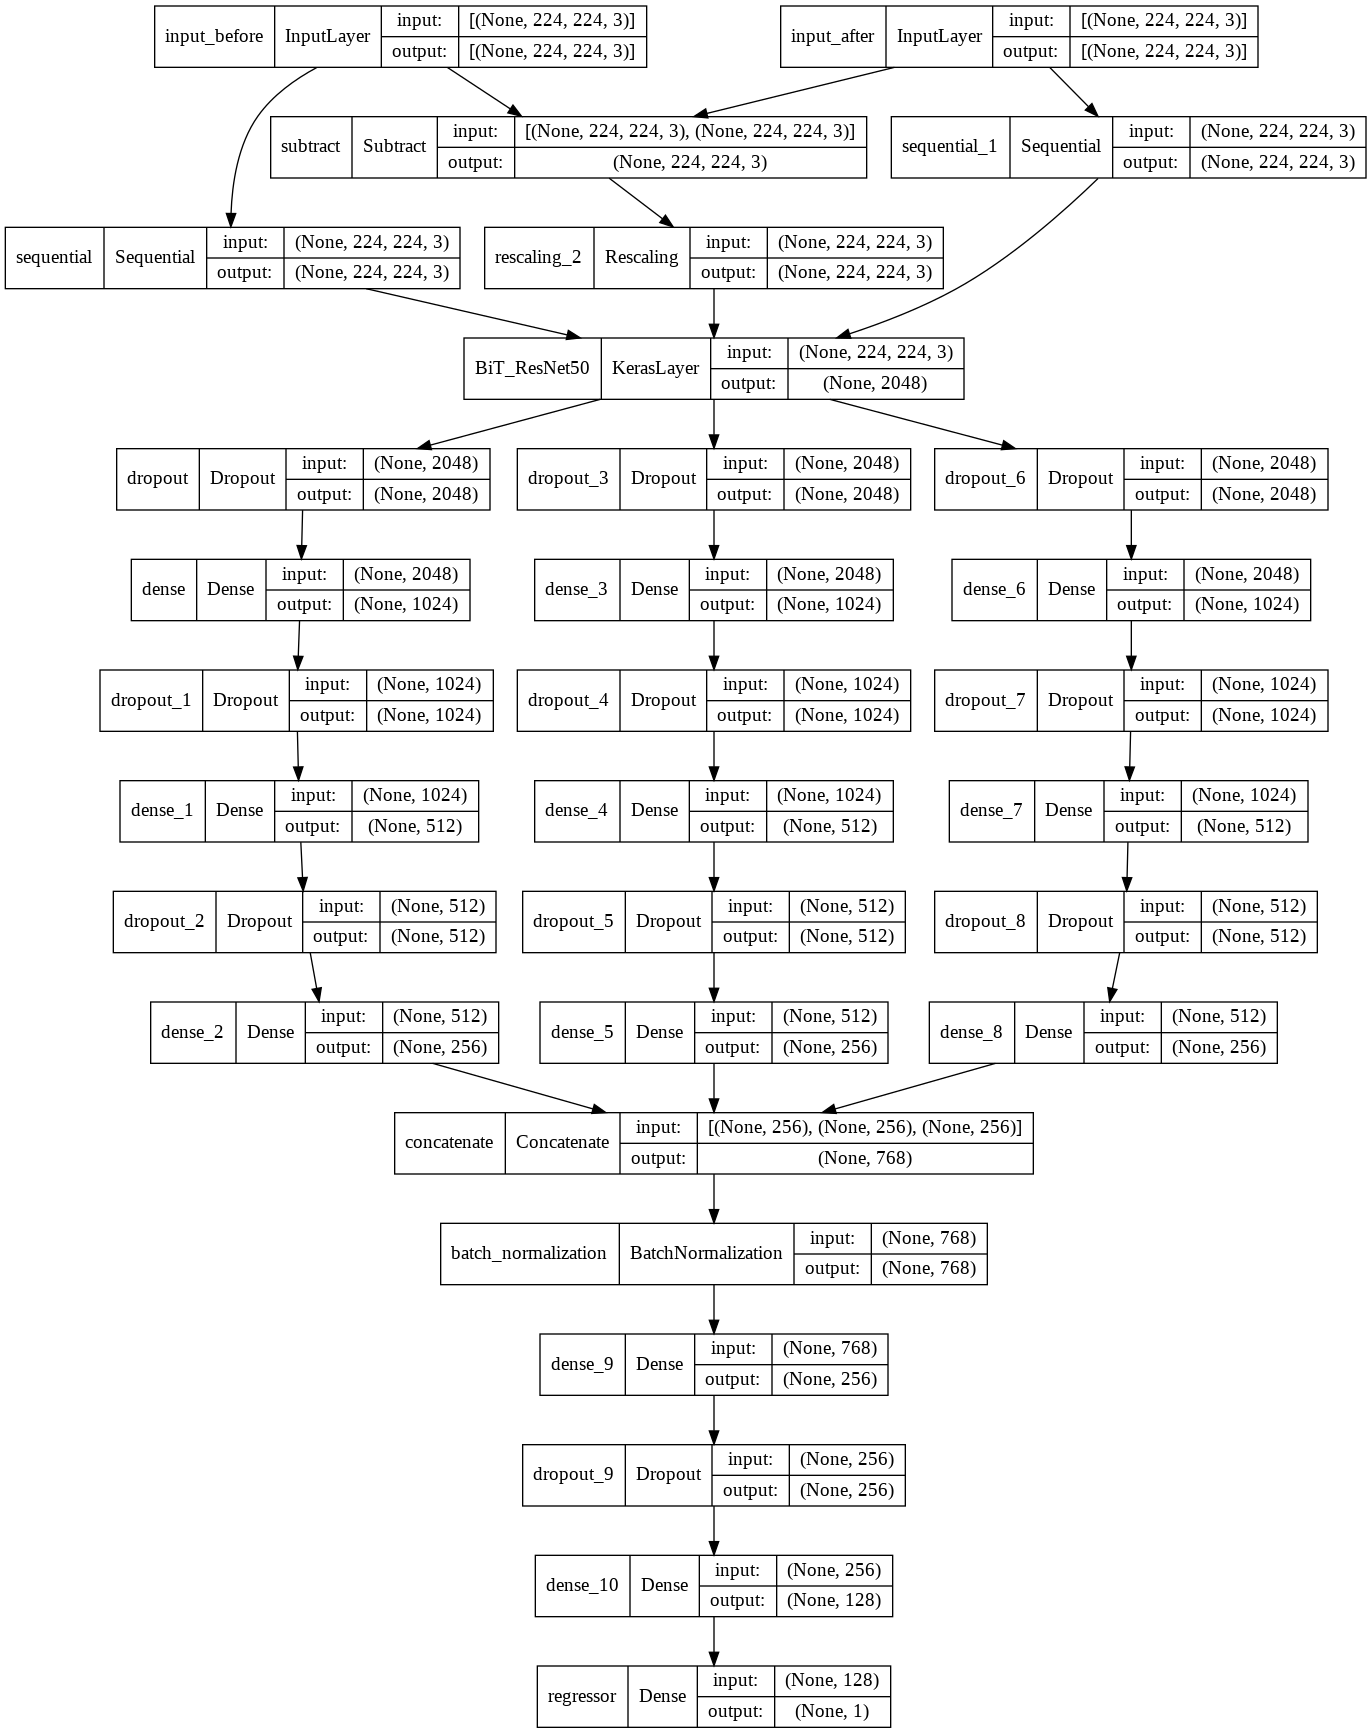

In [ ]:
createFolder(folder_path + "models/" + model_name)
plot_model(createNN_BiT(), to_file=folder_path + "models/" + model_name + "/model_bit.png", show_shapes=True)

In [ ]:
# createFolder(folder_path + "models/" + model_name)
# plot_model(createNN_Effinet(), to_file=folder_path + "models/" + model_name + "/model_effinetv2b0.png", show_shapes=True)

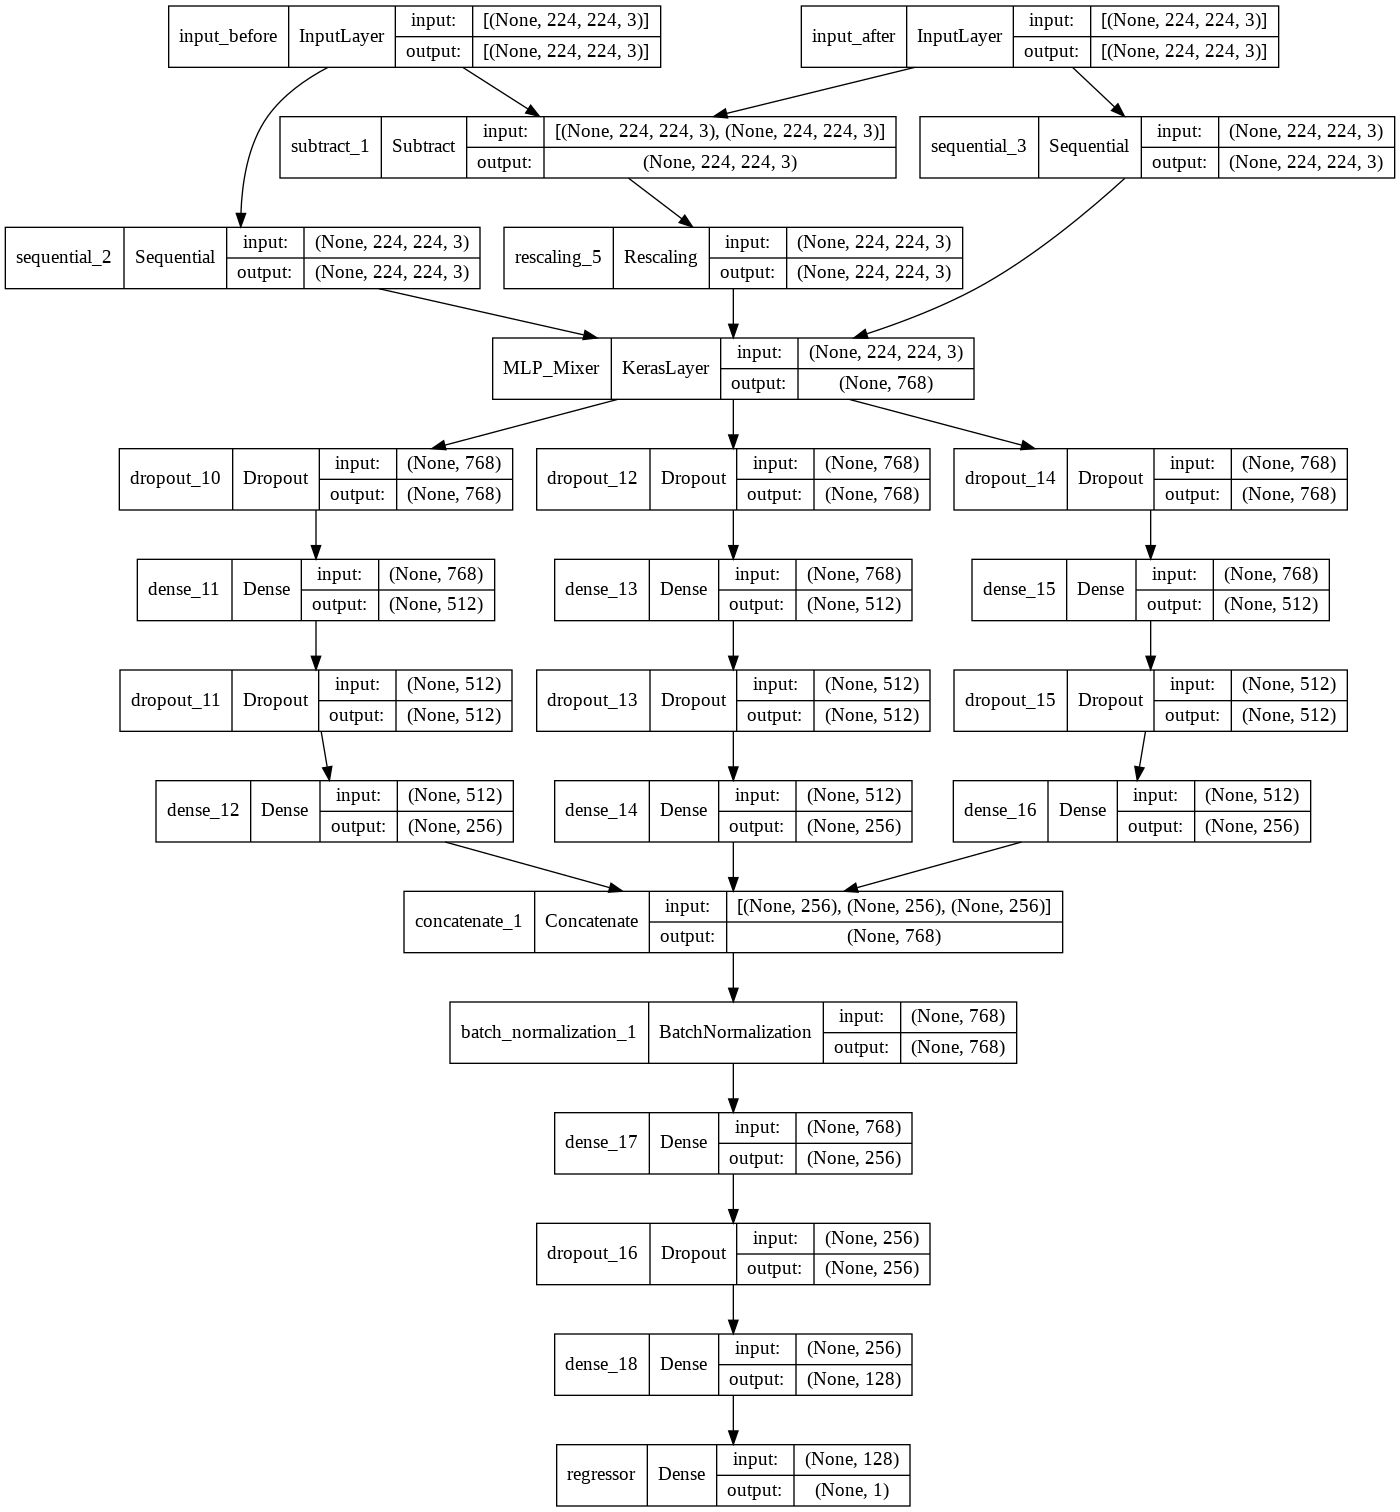

In [ ]:
createFolder(folder_path + "models/" + model_name)
plot_model(createNN_MLP_Mixer(), to_file=folder_path + "models/" + model_name + "/model_mlp_mixer.png", show_shapes=True)

# 10-Folds Training & Inference

In [ ]:
# learning parameter setting
epochs = 30
patient_epochs = 10
batch_size = 32
eta = 1e-4
weight_decay = 1e-4
model_save_flag = False
checkpoint_filepath = folder_path + 'models/tmp_checkpoint/'

# fold spliter setting
kfolds_spliter = StratifiedKFold(10, random_state=1234, shuffle=True)

# result container setting
val_pred = {}
val_pred["bit"] = np.zeros((full_x.shape[0],1))
# val_pred["effinetv2b0"] = np.zeros((full_x.shape[0],1))
val_pred["mlp_mixer"] = np.zeros((full_x.shape[0],1))

test_pred = {}
test_pred["bit"] = np.zeros((test_x.shape[0],1))
# test_pred["effinetv2b0"] = np.zeros((test_x.shape[0],1))
test_pred["mlp_mixer"] = np.zeros((test_x.shape[0],1))

val_perf = {}
val_perf["bit"] = []
# val_perf["effinetv2b0"] = []
val_perf["mlp_mixer"] = []

# CatBoost - GPU

In [ ]:
# # catboost optuna function
# def optuna_objective_function(trial: Trial, train_x, train_y, val_x, val_y, ntrees=5000, eta=1e-2, cat_vars=None):
#     tuning_params = {
#         "n_estimators": int(ntrees / 10),
#         "learning_rate": eta / 10,
#         "max_depth": trial.suggest_int("max_depth", 4, 8, step=1),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.1, 0.9, step=0.1),
#         # "rsm": trial.suggest_float("rsm", 0.5, 0.9, step=0.1),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 10.0, step=0.1),
#         "random_strength": trial.suggest_float("random_strength", 0.01, 1.0, log=True)
#     }

#     model = cat.CatBoostRegressor(boosting_type="Plain", loss_function="RMSE",
#                                   logging_level="Silent", task_type="GPU", thread_count=-1,
#                                   **tuning_params)
#     model.fit(train_x, train_y, cat_features=cat_vars, logging_level='Silent')
#     opt_score = metrics.mean_squared_error(model.predict(val_x), val_y, squared=False)
#     return opt_score

# # ===== CatBoost with feature vector =====
# tmp_time = time()
# print("\n3. CatBoost with feature vector")
# tf.keras.backend.clear_session()
# fold_dir = "fold_" + str(fold)

# wandb.init(
#     project="dacon_plant_growth_timeline_" + model_name,
#     name=fold_dir + "_catboost_optuna",
#     group=plant_type
# )

# # train_ds = create_dataset(full_x["before_path"].iloc[nonkIdx], full_x["after_path"].iloc[nonkIdx], full_y.iloc[nonkIdx].to_frame(),
# #                         batch_size=batch_size, augment=True, shuffle=True)
# # val_ds = create_dataset(full_x["before_path"].iloc[kIdx], full_x["after_path"].iloc[kIdx], full_y.iloc[kIdx].to_frame(),
# #                         batch_size=batch_size, augment=False, shuffle=False)
# # test_ds = create_dataset(test_x["before_path"], test_x["after_path"], None,
# #                          batch_size=batch_size, augment=False, shuffle=False)

# model = Model([model.get_layer(name="input_before").output, model.get_layer(name="input_after").output], model.get_layer(index=-2).output)
# model.trainable = False
# tmp_tensor = layers.Dense(32, kernel_regularizer="l2", name="catboost_fv")(model.get_layer(index=-1).output)  
# tmp_tensor = layers.Dense(1, name="regressor")(tmp_tensor)
# model = Model([model.get_layer(name="input_before").output, model.get_layer(name="input_after").output], tmp_tensor)

# cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=1, factor=0.6, min_lr=1e-5)
# cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
#                                             save_weights_only=True, save_best_only=True)

# model.compile(
#     optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=weight_decay),
#     loss=copy.deepcopy(tf_loss_rmse),
#     metrics=tf_metrics.RootMeanSquaredError(name="rmse")
# )

# model.fit(train_ds, validation_data=val_ds, epochs=10, verbose=0,
#         callbacks=[cb_reduceLR, cb_modelsave, TqdmCallback(verbose=0)])
# model.load_weights(checkpoint_filepath)
# model = Model([model.get_layer(name="input_before").output, model.get_layer(name="input_after").output], model.get_layer(name="catboost_fv").output)

# cat_train_x = model.predict(train_ds)
# cat_val_x = model.predict(val_ds)
# cat_test_x = model.predict(test_ds)

# ntrees = 5000
# catboost_eta = 1e-3
# optuna_timeout = int(1 * 3600 / 10)

# optuna_study = create_study(direction='minimize', sampler=TPESampler())
# optuna_study.optimize(
#     lambda trial: optuna_objective_function(trial, cat_train_x, full_y.iloc[nonkIdx],
#                                             cat_val_x, full_y.iloc[kIdx], ntrees, catboost_eta, None),
#     n_jobs=1, timeout=optuna_timeout, n_trials=10, callbacks=[optuna_wnbcallback(wandb_kwargs={"project": "dacon_plant_growth_timeline_" + model_name,
#                                                                        "name": fold_dir + "_catboost_optuna",
#                                                                        "group": plant_type})]
# )

# # optuna_plt.plot_optimization_history(optuna_study).show(renderer="browser")
# # optuna_plt.plot_param_importances(optuna_study).show(renderer="browser")

# model_cat = cat.CatBoostRegressor(boosting_type="Plain", loss_function="RMSE",
#                                   n_estimators=ntrees, learning_rate=1e-2,
#                                   logging_level="Silent", task_type="GPU", thread_count=-1,
#                                   **optuna_study.best_params)

# model_cat.fit(cat_train_x, full_y.iloc[nonkIdx], cat_features=None,
#               eval_set=[(cat_val_x, full_y.iloc[kIdx])], use_best_model=True,
#               logging_level='Silent', early_stopping_rounds=int(ntrees * 0.2))

# print("CatBoost tuned params --->", optuna_study.best_params)
# print("CatBoost best trees --->", model_cat.best_iteration_)

# val_pred["cat_gbm"][kIdx] = model_cat.predict(cat_val_x).reshape(-1, 1)
# val_perf["cat_gbm"].append(metrics.mean_squared_error(full_y.iloc[kIdx], val_pred["cat_gbm"][kIdx], squared=False))
# test_pred["cat_gbm"] += model_cat.predict(cat_test_x).reshape(-1, 1) / kfolds_spliter.get_n_splits()

# print("Running Time --->", round(time() - tmp_time, 3), "sec\n")
# print(F"{model_name} CatBoost Fold {fold+1} Performance ---> {val_perf['cat_gbm'][-1]}\n")
# print(F"{model_name} CatBoost Average Performance ---> {np.mean(val_perf['cat_gbm'])}\n\n")
# wandb.finish()
# shutil.rmtree(checkpoint_filepath)

# Single Model

In [ ]:
# if os.path.isdir(checkpoint_filepath): shutil.rmtree(checkpoint_filepath)
# seed_everything()
# # fold training
# for fold, (nonkIdx, kIdx) in enumerate(kfolds_spliter.split(full_x, full_y)):
#     print("\n===== Fold", fold+1, "=====\n")
#     tf.keras.backend.clear_session()

#     fold_dir = "fold_" + str(fold)
#     log_dir = folder_path + "models/" + model_name + "/logs/" + fold_dir
#     if os.path.isdir(log_dir): shutil.rmtree(log_dir)
#     createFolder(log_dir)
#     tensorboard_callback = tf_callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
#     try:
#         wandb.tensorboard.patch(root_logdir=log_dir)
#     except:
#         pass
    
#     wandb.init(
#         project="dacon_plant_growth_timeline_" + model_name,
#         name=fold_dir,
#         group=plant_type
#     )
    
#     print("1.", model_name)
#     tmp_time = time()
#     train_ds = create_dataset(full_x["before_path"].iloc[nonkIdx], full_x["after_path"].iloc[nonkIdx], full_y.iloc[nonkIdx].to_frame(),
#                               batch_size=batch_size, augment=True, shuffle=True)
#     val_ds = create_dataset(full_x["before_path"].iloc[kIdx], full_x["after_path"].iloc[kIdx], full_y.iloc[kIdx].to_frame(),
#                             batch_size=batch_size, augment=False, shuffle=False)
#     test_ds = create_dataset(test_x["before_path"], test_x["after_path"], None,
#                              batch_size=batch_size, augment=False, shuffle=False)

#     cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=1, factor=0.6, min_lr=1e-5)
#     cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#     cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
#                                                 save_weights_only=True, save_best_only=True)

#     model = createNN_LearningLayers()
#     model.compile(
#         optimizer = tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#         loss=copy.deepcopy(tf_loss_rmse),
#         metrics=tf_metrics.RootMeanSquaredError(name="rmse")
#     )
#     model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#             callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, tensorboard_callback, TqdmCallback(verbose=0)])
#     model.load_weights(checkpoint_filepath)

#     val_pred["NN_model"][kIdx] = model.predict(val_ds)
#     val_perf["NN_model"].append(metrics.mean_squared_error(full_y.iloc[kIdx], val_pred["NN_model"][kIdx], squared=False))
#     test_pred["NN_model"] += model.predict(test_ds) / kfolds_spliter.get_n_splits()

#     print("Running Time --->", round(time() - tmp_time, 3),"sec")
#     print(F"{model_name} Fold {fold+1} Performance ---> {val_perf['NN_model'][-1]}\n")
#     print(F"{model_name} Average Performance ---> {np.mean(val_perf['NN_model'])}\n")
#     wandb.finish()
#     shutil.rmtree(checkpoint_filepath)

#     if mode_save_flag:
#         tmp_path = createFolder(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)
#         model.save_weights(tmp_path)

#     print("2. Independent Prediction Model")
#     tmp_time = time()
#     # train_ds = create_dataset(full_x["before_path"].iloc[nonkIdx], full_x["after_path"].iloc[nonkIdx], full_y.iloc[nonkIdx].to_frame(),
#     #                           batch_size=batch_size, augment=True, shuffle=True)
#     # val_ds = create_dataset(full_x["before_path"].iloc[kIdx], full_x["after_path"].iloc[kIdx], full_y.iloc[kIdx].to_frame(),
#     #                         batch_size=batch_size, augment=False, shuffle=False)
#     # test_ds = create_dataset(test_x["before_path"], test_x["after_path"], None,
#     #                          batch_size=batch_size, augment=False, shuffle=False)

#     cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=1, factor=0.6, min_lr=1e-5)
#     cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
#     cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
#                                                 save_weights_only=True, save_best_only=True)

#     model = createNN_IndependentLearning()
#     model.compile(
#         optimizer = tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
#         loss=copy.deepcopy(tf_loss_rmse),
#         metrics=tf_metrics.RootMeanSquaredError(name="rmse")
#     )
#     model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
#             callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, tensorboard_callback, TqdmCallback(verbose=0)])
#     model.load_weights(checkpoint_filepath)

#     val_pred["NN_model_indep"][kIdx] = model.predict(val_ds)
#     val_perf["NN_model_indep"].append(metrics.mean_squared_error(full_y.iloc[kIdx], val_pred["NN_model_indep"][kIdx], squared=False))
#     test_pred["NN_model_indep"] += model.predict(test_ds) / kfolds_spliter.get_n_splits()

#     print("Running Time --->", round(time() - tmp_time, 3),"sec")
#     print(F"NN_model_indep Fold {fold+1} Performance ---> {val_perf['NN_model_indep'][-1]}\n")
#     print(F"NN_model_indep Average Performance ---> {np.mean(val_perf['NN_model_indep'])}\n")
#     wandb.finish()
#     shutil.rmtree(checkpoint_filepath)

#     if mode_save_flag:
#         tmp_path = createFolder(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)
#         model.save_weights(tmp_path)

# Blended Model

In [ ]:

seed_everything()
# fold training
for fold, (nonkIdx, kIdx) in enumerate(kfolds_spliter.split(full_x, full_y)):
    print("\n===== Fold", fold+1, "=====\n")     

    # ===== BiT =====
    tmp_time = time()
    print("\nBiT")
    tf.keras.backend.clear_session()
    fold_dir = "fold_" + str(fold)
    log_dir = folder_path + "models/" + model_name + "/logs/" + fold_dir
    if os.path.isdir(log_dir): shutil.rmtree(log_dir)
    createFolder(log_dir)
    tensorboard_callback = tf_callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    try:
        wandb.tensorboard.patch(root_logdir=log_dir)
    except:
        pass
    
    wandb.init(
        project="dacon_plant_growth_timeline_" + model_name,
        group=plant_type,
        name=fold_dir + "_bit",
        tags=["bit"]
    ); wandb.config.step = 0

    train_ds = create_dataset(full_x["before_path"].iloc[nonkIdx], full_x["after_path"].iloc[nonkIdx], full_y.iloc[nonkIdx].to_frame(),
                              batch_size=batch_size, augment=True, shuffle=True)
    val_ds = create_dataset(full_x["before_path"].iloc[kIdx], full_x["after_path"].iloc[kIdx], full_y.iloc[kIdx].to_frame(),
                            batch_size=batch_size, augment=False, shuffle=False)
    test_ds = create_dataset(test_x["before_path"], test_x["after_path"], None,
                             batch_size=batch_size, augment=False, shuffle=False)

    cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=1, factor=0.6, min_lr=1e-7)
    cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
    cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
                                                save_weights_only=True, save_best_only=True)

    model = createNN_BiT()
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
        loss=copy.deepcopy(tf_loss_rmse),
        metrics=tf_metrics.RootMeanSquaredError(name="rmse")
    )
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
            callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, tensorboard_callback, TqdmCallback(verbose=0)])
    model.load_weights(checkpoint_filepath)

    val_pred["bit"][kIdx] = model.predict(val_ds)
    val_perf["bit"].append(metrics.mean_squared_error(full_y.iloc[kIdx], val_pred["bit"][kIdx], squared=False))
    test_pred["bit"] += model.predict(test_ds) / kfolds_spliter.get_n_splits()

    print("Running Time --->", round(time() - tmp_time, 3), "sec\n")
    print(F"bit Fold {fold+1} Performance ---> {val_perf['bit'][-1]}\n")
    print(F"bit Average Performance ---> {np.mean(val_perf['bit'])}\n")
    wandb.log(data={"fold": fold, "rmse_score": val_perf['bit'][-1]}, commit=True)
    wandb.finish()
    shutil.rmtree(checkpoint_filepath)
    shutil.rmtree(log_dir)

    if model_save_flag:
        createFolder(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)
        model.save_weights(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)
    
    # # ===== Effinet =====
    # tmp_time = time()
    # print("\nEfficientNet V2 B0")
    # tf.keras.backend.clear_session()
    # fold_dir = "fold_" + str(fold)
    # log_dir = folder_path + "models/" + model_name + "/logs/" + fold_dir
    # if os.path.isdir(log_dir): shutil.rmtree(log_dir)
    # createFolder(log_dir)
    # tensorboard_callback = tf_callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    # try:
    #     wandb.tensorboard.patch(root_logdir=log_dir)
    # except:
    #     pass
    
    # wandb.init(
    #     project="dacon_plant_growth_timeline_" + model_name,
    #     name=fold_dir + "_effinet",
    #     tags="effinet",
    #     group=plant_type
    # ); wandb.config.step = 0

    # train_ds = create_dataset(full_x["before_path"].iloc[nonkIdx], full_x["after_path"].iloc[nonkIdx], full_y.iloc[nonkIdx].to_frame(),
    #                           batch_size=batch_size, augment=True, shuffle=True)
    # val_ds = create_dataset(full_x["before_path"].iloc[kIdx], full_x["after_path"].iloc[kIdx], full_y.iloc[kIdx].to_frame(),
    #                         batch_size=batch_size, augment=False, shuffle=False)
    # test_ds = create_dataset(test_x["before_path"], test_x["after_path"], None,
    #                          batch_size=batch_size, augment=False, shuffle=False)

    # cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=1, factor=0.6, min_lr=1e-7)
    # cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
    # cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
    #                                             save_weights_only=True, save_best_only=True)

    # model = createNN_Effinet()
    # model.compile(
    #     optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
    #     loss=copy.deepcopy(tf_loss_rmse),
    #     metrics=tf_metrics.RootMeanSquaredError(name="rmse")
    # )
    # model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
    #         callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, tensorboard_callback, TqdmCallback(verbose=0)])
    # model.load_weights(checkpoint_filepath)

    # val_pred["effinetv2b0"][kIdx] = model.predict(val_ds)
    # val_perf["effinetv2b0"].append(metrics.mean_squared_error(full_y.iloc[kIdx], val_pred["effinetv2b0"][kIdx], squared=False))
    # test_pred["effinetv2b0"] += model.predict(test_ds) / kfolds_spliter.get_n_splits()

    # print("Running Time --->", round(time() - tmp_time, 3), "sec\n")
    # print(F"effinetv2b0 Fold {fold+1} Performance ---> {val_perf['effinetv2b0'][-1]}\n")
    # print(F"effinetv2b0 Average Performance ---> {np.mean(val_perf['effinetv2b0'])}\n\n")
    # wandb.finish()
    # wandb.log(data={"fold": fold, "rmse_score": val_perf['effinetv2b0'][-1]}, commit=True)
    # shutil.rmtree(checkpoint_filepath)
    # shutil.rmtree(log_dir)

    # if model_save_flag:
    #     createFolder(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)
    #     model.save_weights(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)

    # ===== MLP Mixer =====
    tmp_time = time()
    print("\nMLP Mixer")
    tf.keras.backend.clear_session()
    fold_dir = "fold_" + str(fold)
    log_dir = folder_path + "models/" + model_name + "/logs/" + fold_dir
    if os.path.isdir(log_dir): shutil.rmtree(log_dir)
    createFolder(log_dir)
    tensorboard_callback = tf_callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    try:
        wandb.tensorboard.patch(root_logdir=log_dir)
    except:
        pass
    
    wandb.init(
        project="dacon_plant_growth_timeline_" + model_name,
        group=plant_type,
        name=fold_dir + "_mlp_mixer",
        tags=["mlp_mixer"]
    ); wandb.config.step = 0

    train_ds = create_dataset(full_x["before_path"].iloc[nonkIdx], full_x["after_path"].iloc[nonkIdx], full_y.iloc[nonkIdx].to_frame(),
                              batch_size=batch_size, augment=True, shuffle=True)
    val_ds = create_dataset(full_x["before_path"].iloc[kIdx], full_x["after_path"].iloc[kIdx], full_y.iloc[kIdx].to_frame(),
                            batch_size=batch_size, augment=False, shuffle=False)
    test_ds = create_dataset(test_x["before_path"], test_x["after_path"], None,
                             batch_size=batch_size, augment=False, shuffle=False)

    cb_reduceLR = tf_callbacks.ReduceLROnPlateau(patience=1, factor=0.6, min_lr=1e-7)
    cb_earlyStopping = tf_callbacks.EarlyStopping(patience=patient_epochs, monitor='val_loss', mode='min')
    cb_modelsave = tf_callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
                                                save_weights_only=True, save_best_only=True)

    model = createNN_MLP_Mixer()
    model.compile(
        optimizer=tfa.optimizers.AdamW(learning_rate=eta, weight_decay=weight_decay),
        loss=copy.deepcopy(tf_loss_rmse),
        metrics=tf_metrics.RootMeanSquaredError(name="rmse")
    )
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0,
            callbacks=[cb_reduceLR, cb_earlyStopping, cb_modelsave, tensorboard_callback, TqdmCallback(verbose=0)])
    model.load_weights(checkpoint_filepath)

    val_pred["mlp_mixer"][kIdx] = model.predict(val_ds)
    val_perf["mlp_mixer"].append(metrics.mean_squared_error(full_y.iloc[kIdx], val_pred["mlp_mixer"][kIdx], squared=False))
    test_pred["mlp_mixer"] += model.predict(test_ds) / kfolds_spliter.get_n_splits()

    print("Running Time --->", round(time() - tmp_time, 3), "sec\n")
    print(F"mlp_mixer Fold {fold+1} Performance ---> {val_perf['mlp_mixer'][-1]}\n")
    print(F"mlp_mixer Average Performance ---> {np.mean(val_perf['mlp_mixer'])}\n")
    wandb.log(data={"fold": fold, "rmse_score": val_perf['mlp_mixer'][-1]}, commit=True)
    wandb.finish()
    shutil.rmtree(checkpoint_filepath)
    shutil.rmtree(log_dir)

    if model_save_flag:
        createFolder(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)
        model.save_weights(folder_path + "models/" + model_name + "/checkpoints/" + fold_dir)


===== Fold 1 =====


BiT


wandb: Currently logged in as: frony (use `wandb login --relogin` to force relogin)


0epoch [00:00, ?epoch/s]

Running Time ---> 2189.463 sec

bit Fold 1 Performance ---> 1.4402906971794942

bit Average Performance ---> 1.4402906971794942



fold,▁
global_step,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▄▄
train/epoch_lr,███▅▅▄▄▄▃▃▂▂▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄
train/global_step,▁▁▁▂▂▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇████
validation/epoch_loss,▇▅▆▃▃▂▂▂▁▁▁▁▁▂▃▄▅▇█
validation/epoch_rmse,▇▅▆▃▃▂▂▂▁▁▁▁▁▂▃▄▅▇█
validation/evaluation_loss_vs_iterations,▇▅▆▃▃▂▂▂▁▁▁▁▁▂▃▄▅▇█
validation/evaluation_rmse_vs_iterations,▇▅▆▃▃▂▂▂▁▁▁▁▁▂▃▄▅▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

Running Time ---> 3296.561 sec

mlp_mixer Fold 1 Performance ---> 1.1502945073800517

mlp_mixer Average Performance ---> 1.1502945073800517



fold,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
rmse_score,▁
train/epoch_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆█
train/epoch_lr,████████▅▅▄▄▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆
train/global_step,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
validation/epoch_loss,█▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▆
validation/epoch_rmse,█▅▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▆
validation/evaluation_loss_vs_iterations,█▄▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▆
validation/evaluation_rmse_vs_iterations,█▅▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▆



===== Fold 2 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_1/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_1/validation


Running Time ---> 3022.44 sec

bit Fold 2 Performance ---> 1.3028207223069532

bit Average Performance ---> 1.3715557097432236



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇
train/epoch_lr,████▅▅▅▄▄▄▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
validation/epoch_loss,▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▅▆▇█
validation/epoch_rmse,▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▅▆▇█
validation/evaluation_loss_vs_iterations,▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▅▆▇█
validation/evaluation_rmse_vs_iterations,▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▅▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_1/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_1/validation


Running Time ---> 3166.338 sec

mlp_mixer Fold 2 Performance ---> 1.1567459927321124

mlp_mixer Average Performance ---> 1.153520250056082



fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
train/epoch_lr,████████▅▄▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
train/global_step,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
validation/epoch_loss,█▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
validation/epoch_rmse,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
validation/evaluation_loss_vs_iterations,█▃▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
validation/evaluation_rmse_vs_iterations,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅



===== Fold 3 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_2/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_2/validation


Running Time ---> 2576.402 sec

bit Fold 3 Performance ---> 1.7151019357526645

bit Average Performance ---> 1.4860711184130373



fold,▁
global_step,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
rmse_score,▁
train/epoch_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆█
train/epoch_lr,███▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▅▆▇
train/global_step,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
validation/epoch_loss,▇▅▆▄▅▃▂▂▁▂▁▁▁▁▁▂▂▃▄▅▆▇█
validation/epoch_rmse,▇▅▆▄▅▃▂▂▂▂▁▁▁▁▁▂▂▃▄▅▆▇█
validation/evaluation_loss_vs_iterations,▇▅▆▄▅▃▂▂▁▂▁▁▁▁▁▂▂▃▄▅▆▇█
validation/evaluation_rmse_vs_iterations,▇▅▆▄▅▃▂▂▂▂▁▁▁▁▁▂▂▃▄▅▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_2/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_2/validation


Running Time ---> 3058.724 sec

mlp_mixer Fold 3 Performance ---> 1.3214007079891628

mlp_mixer Average Performance ---> 1.2094804027004422



fold,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆█
train/epoch_lr,███████████▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
validation/epoch_loss,█▄▃▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆
validation/epoch_rmse,█▄▃▃▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆
validation/evaluation_loss_vs_iterations,█▄▃▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆
validation/evaluation_rmse_vs_iterations,█▄▃▃▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▂▂▃▄▄▅▆



===== Fold 4 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_3/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_3/validation


Running Time ---> 3232.818 sec

bit Fold 4 Performance ---> 1.3146227369024848

bit Average Performance ---> 1.443209023035399



fold,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
rmse_score,▁
train/epoch_loss,▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇█
train/epoch_lr,█████▅▅▅▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆▇
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
validation/epoch_loss,▆▆▄▃▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▇█
validation/epoch_rmse,▆▆▄▃▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▇█
validation/evaluation_loss_vs_iterations,▆▆▄▃▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▇█
validation/evaluation_rmse_vs_iterations,▆▆▄▃▄▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▄▅▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_3/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_3/validation


Running Time ---> 2961.811 sec

mlp_mixer Fold 4 Performance ---> 1.197664994295425

mlp_mixer Average Performance ---> 1.206526550599188



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
train/epoch_lr,███████▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
validation/epoch_loss,█▅▄▄▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
validation/epoch_rmse,█▅▄▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
validation/evaluation_loss_vs_iterations,█▅▄▄▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
validation/evaluation_rmse_vs_iterations,█▅▄▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅



===== Fold 5 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_4/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_4/validation


Running Time ---> 2862.041 sec

bit Fold 5 Performance ---> 1.2924597221967606

bit Average Performance ---> 1.4130591628676714



fold,▁
global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
rmse_score,▁
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇
train/epoch_lr,███▅▅▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
train/global_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇████
validation/epoch_loss,▇▄▆▃▃▂▃▂▂▂▂▁▁▁▁▁▁▂▃▄▅▆▇█
validation/epoch_rmse,▇▄▆▃▃▂▃▂▂▂▂▁▁▁▁▁▁▂▃▄▅▆▇█
validation/evaluation_loss_vs_iterations,▇▄▆▃▃▂▃▂▂▂▂▁▁▁▁▁▁▂▃▄▅▆▇█
validation/evaluation_rmse_vs_iterations,▇▄▆▃▃▂▃▂▂▂▂▁▁▁▁▁▁▂▃▄▅▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_4/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_4/validation


Running Time ---> 2991.605 sec

mlp_mixer Fold 5 Performance ---> 1.2218934012331832

mlp_mixer Average Performance ---> 1.209599920725987



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇
train/epoch_lr,████▅▄▄▄▄▄▄▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
validation/epoch_loss,█▄▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
validation/epoch_rmse,█▄▂▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
validation/evaluation_loss_vs_iterations,█▄▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
validation/evaluation_rmse_vs_iterations,█▄▂▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆



===== Fold 6 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_5/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_5/validation


Running Time ---> 3246.569 sec

bit Fold 6 Performance ---> 1.37107427091329

bit Average Performance ---> 1.4060616808752746



fold,▁
global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆▇█
train/epoch_lr,██████▅▄▄▄▄▄▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▄▅▆▇
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
validation/epoch_loss,▅▄▃▃▂▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▃▄▅▆▇█
validation/epoch_rmse,▅▄▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇█
validation/evaluation_loss_vs_iterations,▅▄▃▃▂▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▃▄▅▆▇█
validation/evaluation_rmse_vs_iterations,▅▄▃▃▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_5/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_5/validation


Running Time ---> 2424.516 sec

mlp_mixer Fold 6 Performance ---> 1.314784842223178

mlp_mixer Average Performance ---> 1.2271307409755188



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██
rmse_score,▁
train/epoch_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
train/epoch_lr,██████▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
train/global_step,▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
validation/epoch_loss,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/epoch_rmse,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/evaluation_loss_vs_iterations,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/evaluation_rmse_vs_iterations,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▄▅



===== Fold 7 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_6/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_6/validation


Running Time ---> 2747.706 sec

bit Fold 7 Performance ---> 1.415234182983096

bit Average Performance ---> 1.407372038319249



fold,▁
global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇
train/epoch_lr,████▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation/epoch_loss,█▄▃▄▄▂▂▂▁▂▁▁▁▁▁▁▁▂▂▃▅▆▇█
validation/epoch_rmse,█▄▃▄▄▂▂▂▁▂▁▁▁▁▁▁▁▂▂▃▅▆▇█
validation/evaluation_loss_vs_iterations,█▄▃▄▄▂▂▂▁▂▁▁▁▁▁▁▁▂▂▃▅▆▇█
validation/evaluation_rmse_vs_iterations,█▄▃▄▄▂▂▂▁▂▁▁▁▁▁▁▁▂▂▃▅▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_6/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_6/validation


Running Time ---> 3534.144 sec

mlp_mixer Fold 7 Performance ---> 1.0931986695639204

mlp_mixer Average Performance ---> 1.207997587916719



fold,▁
global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
rmse_score,▁
train/epoch_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅
train/epoch_lr,███████▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
validation/epoch_loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄
validation/epoch_rmse,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄
validation/evaluation_loss_vs_iterations,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄
validation/evaluation_rmse_vs_iterations,█▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄



===== Fold 8 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_7/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_7/validation


Running Time ---> 3058.875 sec

bit Fold 8 Performance ---> 1.41326716798602

bit Average Performance ---> 1.4081089295275953



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆█
train/epoch_lr,███▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation/epoch_loss,▇▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▄▆▇█
validation/epoch_rmse,▇▄▄▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▄▆▇█
validation/evaluation_loss_vs_iterations,▇▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▄▆▇█
validation/evaluation_rmse_vs_iterations,▇▄▄▃▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▄▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_7/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_7/validation


Running Time ---> 2884.053 sec

mlp_mixer Fold 8 Performance ---> 1.1551282786596697

mlp_mixer Average Performance ---> 1.2013889242595877



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
train/epoch_lr,████████▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
train/global_step,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
validation/epoch_loss,█▄▄▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/epoch_rmse,█▄▄▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/evaluation_loss_vs_iterations,█▄▄▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/evaluation_rmse_vs_iterations,█▄▄▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅



===== Fold 9 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_8/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_8/validation


Running Time ---> 3157.42 sec

bit Fold 9 Performance ---> 1.246342827661712

bit Average Performance ---> 1.3901349182091638



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
rmse_score,▁
train/epoch_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
train/epoch_lr,█████▅▅▅▅▄▄▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
validation/epoch_loss,▇▅▄▃▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▄▆▇█
validation/epoch_rmse,▇▅▄▃▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▄▆▇█
validation/evaluation_loss_vs_iterations,▇▅▄▃▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▄▆▇█
validation/evaluation_rmse_vs_iterations,▇▅▄▃▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▄▆▇█



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_8/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_8/validation


Running Time ---> 3025.797 sec

mlp_mixer Fold 9 Performance ---> 1.2780744444473795

mlp_mixer Average Performance ---> 1.209909537613787



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
rmse_score,▁
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆▇
train/epoch_lr,█████▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
validation/epoch_loss,█▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
validation/epoch_rmse,█▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
validation/evaluation_loss_vs_iterations,█▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆
validation/evaluation_rmse_vs_iterations,█▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▆



===== Fold 10 =====


BiT


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_9/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_9/validation


Running Time ---> 3037.826 sec

bit Fold 10 Performance ---> 1.3904763924028547

bit Average Performance ---> 1.3901690656285328



fold,▁
global_step,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
rmse_score,▁
train/epoch_loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
train/epoch_lr,███▅▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▅
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
validation/epoch_loss,█▄▄▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▇
validation/epoch_rmse,█▄▄▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
validation/evaluation_loss_vs_iterations,█▄▄▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▇
validation/evaluation_rmse_vs_iterations,█▄▄▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆



MLP Mixer


0epoch [00:00, ?epoch/s]

wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_9/train
wandb: WARNING Found logdirectory outside of given root_logdir, dropping given root_logdir for eventfile in /content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/logs/fold_9/validation


Running Time ---> 2712.075 sec

mlp_mixer Fold 10 Performance ---> 1.1820794275507034

mlp_mixer Average Performance ---> 1.2071265266074787



fold,▁
global_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
rmse_score,▁
train/epoch_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆
train/epoch_lr,████▅▄▄▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
train/epoch_rmse,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇██
validation/epoch_loss,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/epoch_rmse,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/evaluation_loss_vs_iterations,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅
validation/evaluation_rmse_vs_iterations,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅


In [ ]:
# save prediction
createFolder(folder_path + "models/" + model_name + "/" + plant_type + "_pred/")
createFolder(folder_path + "models/" + model_name + "/" + plant_type + "_pred/")
for i in val_pred.keys():
    dataframe(val_pred[i]).to_csv(folder_path + "models/" + model_name + "/" + plant_type + "_pred/" + i + "_fold_pred_" + ".csv")
for i in test_pred.keys():
    dataframe(test_pred[i]).to_csv(folder_path + "models/" + model_name + "/" + plant_type + "_pred/" + i + "_test_pred_" + ".csv")

# Meta Learning

In [ ]:
folder_path + "models/" + model_name + "/" + plant_type + "_pred/" + i + "_fold_pred_" + ".csv"

'/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/LT_pred/bit_fold_pred_.csv'

In [ ]:
for i in val_pred.keys():
    val_pred[i] = read_csv(folder_path + "models/" + model_name + "/" + plant_type + "_pred/" + i + "_fold_pred_" + ".csv").iloc[:,1].to_numpy()[..., np.newaxis]
for i in test_pred.keys():
    test_pred[i] = read_csv(folder_path + "models/" + model_name + "/" + plant_type + "_pred/" + i + "_test_pred_" + ".csv").iloc[:,1].to_numpy()[..., np.newaxis]

In [ ]:
val_pred["meta_learner"] = np.zeros((full_x.shape[0],1))
test_pred["meta_learner"] = np.zeros((test_x.shape[0],1))
val_perf["meta_learner"] = []

meta_learner = lm.LinearRegression()

pred_concat = []
for i in val_pred.keys():
    if i != "meta_learner":
        pred_concat.append(val_pred[i])
pred_concat = np.concatenate(pred_concat, axis=1)
meta_learner.fit(pred_concat, full_y)
print(pred_concat.shape)
val_pred["meta_learner"] = meta_learner.predict(pred_concat).reshape(-1,1)
val_perf["meta_learner"].append(metrics.mean_squared_error(full_y, val_pred["meta_learner"], squared=False))

pred_concat = []
for i in test_pred.keys():
    if i != "meta_learner":
        pred_concat.append(test_pred[i])
pred_concat = np.concatenate(pred_concat, axis=1)
print(pred_concat.shape)
test_pred["meta_learner"] = meta_learner.predict(pred_concat).reshape(-1,1)

print("\nCoefficient on meat learner")
print(list(val_pred.keys())[:-1])
print(meta_learner.coef_)

(7801, 2)
(2161, 2)

Coefficient on meat learner
['bit', 'mlp_mixer']
[0.42518877 0.58964749]


In [ ]:
# save prediction
for i in val_pred.keys():
    if i == "meta_learner":
        dataframe(val_pred[i]).to_csv(folder_path + "models/" + model_name + "/" + plant_type + "_pred/" + i + "_fold_pred_" + ".csv")
for i in test_pred.keys():
    if i == "meta_learner":
        dataframe(test_pred[i]).to_csv(folder_path + "models/" + model_name + "/" + plant_type + "_pred/" + i + "_test_pred_" + ".csv")

# Validation performance summary

In [ ]:
print("===== 10-Folds Average Score =====\n")
for k, v in val_perf.items():
    print(k, "--->", np.mean(v))
series(val_perf).to_csv(folder_path + "models/" + model_name + "/validation_score_" + plant_type + ".csv", index=False)

===== 10-Folds Average Score =====

bit ---> nan
mlp_mixer ---> nan
meta_learner ---> 1.0804913070495532


In [ ]:
# compare validation score
tmp_model_name = "EffinetV2B0_LP_Try1" # best public score
print(F"===== {tmp_model_name} 10-Folds Average Score =====\n")
tmp_perf = read_csv(folder_path + "models/" + tmp_model_name + "/validation_score_" + plant_type + ".csv")
print(tmp_model_name, "--->", np.mean(tmp_perf.iloc[:,0]), "\n\n")

# compare validation score
tmp_model_name = "BiT_LP_Try3"
print(F"===== {tmp_model_name} 10-Folds Average Score =====\n")
tmp_perf = read_csv(folder_path + "models/" + tmp_model_name + "/validation_score_" + plant_type + ".csv")
print(tmp_model_name, "--->", np.mean(tmp_perf.iloc[:,0]))

===== EffinetV2B0_LP_Try1 10-Folds Average Score =====

EffinetV2B0_LP_Try1 ---> 1.6225085888496218 


===== BiT_LP_Try3 10-Folds Average Score =====

BiT_LP_Try3 ---> 1.6315964067090676


# Submission

In [ ]:
# submission = read_csv(folder_path + "models/submission.csv")
# tmp_pred = [1 if i < 1 else i for i in test_pred["meta_learner"].flatten()]
# submission["time_delta"].iloc[test_plant_idx] = tmp_pred
# submission.to_csv(folder_path + "models/" + model_name + "/submission_" + plant_type + ".csv", index=False)
# submission.head(10)

,idx,time_delta
0,0,23.871761
1,1,27.781441
2,2,-1.000000
3,3,-1.000000
4,4,22.357461
5,5,19.162939
6,6,18.062462
7,7,-1.000000
8,8,1.705946
9,9,28.626806


In [ ]:
# BiT single
# combining plant type prediction
submission = read_csv(folder_path + "models/submission.csv")
submission["time_delta"] = submission["time_delta"].astype("float")
submission["time_delta"][[True if i not in list(test_plant_idx) else False for i in submission.index]] = read_csv("/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/BC_pred/bit_test_pred.csv").iloc[:,1].to_numpy(dtype="float")
submission["time_delta"][[True if i in list(test_plant_idx) else False for i in submission.index]] = read_csv("/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/LT_pred/bit_test_pred_.csv").iloc[:,1].to_numpy(dtype="float")
submission["time_delta"] = [1 if i < 1 else i for i in submission["time_delta"]]
submission.to_csv(folder_path + "models/" + model_name + "/submission_" + "final_" + "BiT" + ".csv", index=False)
submission.head(30)

,idx,time_delta
0,0,24.452700
1,1,24.373171
2,2,3.139734
3,3,2.841357
4,4,22.042957
5,5,18.081014
6,6,17.456871
7,7,11.465919
8,8,2.003041
9,9,27.426733


In [ ]:
# MLP Mixer single
# combining plant type prediction
submission = read_csv(folder_path + "models/submission.csv")
submission["time_delta"] = submission["time_delta"].astype("float")
submission["time_delta"][[True if i not in list(test_plant_idx) else False for i in submission.index]] = read_csv("/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/BC_pred/mlp_mixer_test_pred.csv").iloc[:,1].to_numpy(dtype="float")
submission["time_delta"][[True if i in list(test_plant_idx) else False for i in submission.index]] = read_csv("/content/drive/MyDrive/Colab Notebooks/projects/Dacon/plant_growth_timeline_prediction/models/BiT_EffinetV2B0_MLPMixer_Try2/LT_pred/mlp_mixer_test_pred_.csv").iloc[:,1].to_numpy(dtype="float")
submission["time_delta"] = [1 if i < 1 else i for i in submission["time_delta"]]
submission.to_csv(folder_path + "models/" + model_name + "/submission_" + "final_" + "MLP_Mixer" + ".csv", index=False)
submission.head(30)

,idx,time_delta
0,0,22.721554
1,1,29.409439
2,2,3.858819
3,3,3.265341
4,4,21.891051
5,5,19.330286
6,6,17.914018
7,7,13.294527
8,8,1.318135
9,9,28.641225
